In [71]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
llm.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today?'

In [72]:
from langchain.tools import tool

#### These are my custome tools

In [73]:
@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

#### importing inbuilt tool

In [74]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()

In [75]:
search.invoke("what is the latest on ISRO?")

"Scheduled for docking on January 7, the mission faced delays as Isro said it needed more time to conduct simulations before the docking. This prompted a rescheduling to January 9, but further adjustments were necessary to ensure the safety and precision of the experimental satellites.The two spacecraft, named SDX01 (Chaser) and SDX02 (Target), were launched on December 30, 2024, aboard the ... Isro's ambitious Space Docking Experiment (SpaDeX) mission has reached a critical stage with the two satellites now positioned at a crucial proximity point. Listen to Story Isro has successfully arrested the satellites' drift at an Inter Satellite Distance (ISD) of 230 metres, with both spacecraft ... The Indian Space Research Organisation (Isro) is set to launch its 'Space Docking Experiment' (SpaDex) mission at 10 pm tonight. Using the Isro's PSLV-C60, the mission will deploy two 220-kg satellites into a 740 km orbit to demonstrate satellite docking. This milestone is crucial for future space 

In [76]:
tools=[multiply,add,divide,search]

In [77]:
## llm now has capability which tool needs to be called 
llm_with_tools=llm.bind_tools(tools)

In [78]:
response1=llm_with_tools.invoke("hi")
response1.content

"It seems like you're trying to demonstrate how to call one of the functions, but I need more details to assist you properly. Could you please clarify which function you'd like to use and provide the necessary arguments?"

In [79]:
## there is not tool call for hi
response1.tool_calls

[]

In [80]:
response2=llm_with_tools.invoke("what is 2 +2")
response2.content

''

In [81]:
## here LLM called the tool automatically
response2.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 's2dtmargq',
  'type': 'tool_call'}]

In [82]:
response3=llm_with_tools.invoke("what is current age of Naredra Modi")
response3.content

## whenever LLM decide to call a tool content is empty
## tool is not called yet

''

In [83]:
response3.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'current age of Narendra Modi'},
  'id': 'zxseb0bkb',
  'type': 'tool_call'}]

In [84]:
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import MessagesState,StateGraph,END,START
from langgraph.prebuilt import ToolNode, tools_condition

In [85]:
SYSTEM_PROMT="You are a healpful assistant tasked with using search and performing arithmatic on a set of inputs."

In [106]:
def fun_decision(state:MessagesState):
    user_question=state["messages"]
    input_question=[SYSTEM_PROMT]+user_question
    response=llm_with_tools.invoke(input_question)

    return{
        "messages":[response]
    }

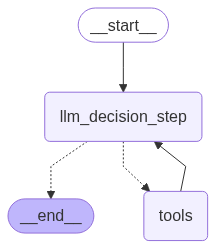

In [107]:
builder=StateGraph(MessagesState)

builder.add_node("llm_decision_step",fun_decision)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"llm_decision_step")

# tools_condition is inbuilt router
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition
    )

builder.add_edge("tools","llm_decision_step")

react_graph=builder.compile()

from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [ ]:
message=[HumanMessage(content="what is 2 times of naredra modi age?")]

react_graph.invoke({"messages":message})

## here only multiply tool called ## because LLM know the age

{'messages': [HumanMessage(content='what is 2 times of naredra modi age?', additional_kwargs={}, response_metadata={}, id='f2a7f39c-ff8d-4e5e-a389-cfd9b9f19207'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qy95t6eta', 'function': {'arguments': '{"a":73,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 427, 'total_tokens': 583, 'completion_time': 0.567272727, 'prompt_time': 0.035249441, 'queue_time': 0.056829750000000005, 'total_time': 0.602522168}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9603353-98dd-40aa-ba1a-0f7cdeafced1-0', tool_calls=[{'name': 'multiply', 'args': {'a': 73, 'b': 2}, 'id': 'qy95t6eta', 'type': 'tool_call'}], usage_metadata={'input_tokens': 427, 'output_tokens': 156, 'total_tokens': 583}),
  ToolMessage(content='146', name='multiply', id='f7776368-93da-4893-8ac2

In [110]:
message=[HumanMessage(content="what is half of mukesh ambani wealth?")]

react_graph.invoke({"messages":message})

## here duckduckgo_search and divide tool called ## because LLM does not the wealth

{'messages': [HumanMessage(content='what is half of mukesh ambani wealth?', additional_kwargs={}, response_metadata={}, id='e5ebc20b-388d-417e-a5e7-edc7df81e5a6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6jqsvdn7q', 'function': {'arguments': '{"query":"Mukesh Ambani net worth 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 191, 'prompt_tokens': 425, 'total_tokens': 616, 'completion_time': 0.694545455, 'prompt_time': 0.02721085, 'queue_time': 0.053395370000000004, 'total_time': 0.721756305}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5319151c-7310-42fd-a320-25103fd17805-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Mukesh Ambani net worth 2023'}, 'id': '6jqsvdn7q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 425, 'output_tokens': 191, 'total_tokens': 616}),
  Too

## Finance Tool Example

In [112]:
import yfinance as yf

In [113]:

@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

In [114]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $199.20.'

In [115]:
tools.append(get_stock_price)

In [116]:
tools

[StructuredTool(name='multiply', description='Multiply two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The product of a and b.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001E268292340>),
 StructuredTool(name='add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of a and b.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000001E268291620>),
 StructuredTool(name='divide', description='Divide two integers.\n\nArgs:\n    a (int): The numerator.\n    b (int): The denominator (must not be 0).\n\nReturns:\n    float: The result of division.', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x000001E2682925C0>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', 

In [117]:
llm_with_tools=llm.bind_tools(tools)

In [118]:
response=llm_with_tools.invoke("can you give me a latest stock price of adani greens?")

In [120]:
response.content

''

In [121]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.BO'},
  'id': 'nyn3nmh6d',
  'type': 'tool_call'}]

In [137]:
SYSTEM_PROMT= SystemMessage(content="You are a healpful assistant tasked with using search, the yahoo finance tool and performing arithmatic on a set of inputs.")

def fun_finance(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [138]:
workflow=StateGraph(MessagesState)

workflow.add_node("llm_decision_step",fun_finance)
workflow.add_node("tools",ToolNode(tools))

workflow.add_edge(START,"llm_decision_step")
workflow.add_conditional_edges("llm_decision_step",tools_condition)

workflow.add_edge("tools","llm_decision_step")

react_graph2=workflow.compile()

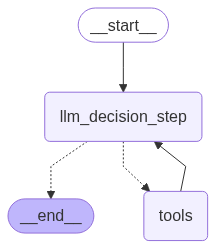

In [139]:
display(Image(react_graph2.get_graph(xray=True).draw_mermaid_png()))

In [145]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
results=react_graph2.invoke({"messages":messages})

for r in results["messages"]:
    r.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (8x030fa3h)
 Call ID: 8x030fa3h
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (58yg4gpq7)
 Call ID: 58yg4gpq7
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================

To add 1000 to the current stock price of Apple, follow these steps:

1. **Find the current stock price of Apple (AAPL):**
   - Use the `get_stock_price` tool

In [147]:
messages = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
results = react_graph2.invoke({"messages":messages})

for r in results["messages"]:
    r.pretty_print()

================================ Human Message =================================

can you give me 2 times of current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (r5xs5hcg3)
 Call ID: r5xs5hcg3
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (5t22zjsd9)
 Call ID: 5t22zjsd9
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (70cs52er5)
 Call ID: 70cs52er5
  Args:
    ticker: AAPL
===========================